In [1]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler # we are not using STandardScaler as it intriduces negative values in the data 
# and some of the models does'nt process the negative values well 
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM,Dense,Dropout
# Lstm is the main layer, Dense allow us to add layers and dropout(helps remove overfitting) allow us to remove layers 
import os 
import tensorflow as tf 
#from fbprophet import Prophet
from statsmodels.tsa.holtwinters import Holt
import statsmodels.api as sm
import numpy as np

In [28]:
def adf_test(series):
    result=adfuller(series,autolag='AIC')
    labels =['Test stats','P-value','#lags used','# observations']
    out=pd.Series(result[0:4],index=labels)
    print(out.to_string()) 
    if result[1] <= 0.05:
        print('Reject the null hypothesis,i.e data has no unit root and is stationery\n')
    else:
        print('Failed to reject null hypothesis, data has a unit root and is non stationery\n') 

In [30]:
# Getting the data of the required Source we can use multiple platforms like yahoo finance, Alpha Vantage and Rapid API 
# I will be using two of the methods to get the data 
# Using Rapid Api 
# to check whether the series is linear with itself or not we will use the portmanteau test 
def get_data(stockname):
    url = "https://twelve-data1.p.rapidapi.com/time_series"
    querystring = {"symbol":stockname,"interval":"1day","outputsize":"3000","format":"csv"}
    headers = {
        "X-RapidAPI-Key": "99ecbdaf9fmshd0e25a4a5fc49d9p1a20afjsncfcc8ab90ce1",
        "X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
            }
    response = requests.request("GET", url, headers=headers, params=querystring)
    df=pd.read_csv(io.StringIO(response.text.replace(';',',')))# converting file to CSV
    df.rename(columns={'datetime':'Date'},inplace=True)
    df['Date']=pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df.sort_index(inplace=True)
    print("We are currently dealing with only open prices \n")
    close_prices=df['close']
    if close_prices.isna().sum() != 0:
        df['close'].dropna(inplace=True)
    else:
        print("No Null values \n")
    print('Dickey fueller test without differencing of the data \n')
    adf_test(close_prices)
    print("Now we are adjsuting the frequency of the data \n")
    close_prices=close_prices.asfreq('D')
    print("Now we are adding the missing values in our data \n")
    close_prices=close_prices.interpolate(method='cubic')
    # after differencing the series may contain null values in it so in order to handle that we can interpolate our data with fake values
    return close_prices

In [31]:
def create_my_dataset(data):
    x=[]
    y=[]
    for i in range(50,data.shape[0]):
        # from 50 to number of rows in the dataset
        x.append(data[i-50:i,0])
        y.append(data[i,0])
        # this will give a single value out in the data 
    x=np.array(x)
    y=np.array(y)
    return x,y

In [32]:
def model0(prices):
    # this is for holt model
    holt = Holt(prices,initialization_method = 'legacy-heuristic')
    result=holt.fit()
    predicted_values=result.forecast(5)
    return predicted_values

In [33]:
def model1(prices):
    # this is the holtwinters model 
    hw1=ExponentialSmoothing(prices,initialization_method ='legacy-heuristic',trend='add',seasonal ='add')
    # we can suppy other hyper parametrs as well
    model = hw1.fit()
    predict=model.fittedvalues
    predicted_values=model.forecast(5)
    return predicted_values

In [34]:
def model2(prices):
    # this is ARIMA Model
    a_a=auto_arima(prices,stepwise=False,seasonal=False,trace=False) 
    model=ARIMA(prices,order=a_a.order) 
    result=model.fit()
    predicted_values= result.forecast(steps=5)
    return predicted_values

In [35]:
def model3(prices):
    # this model here is for SARIMA 
    a_a=auto_arima(prices,stepwise=False,seasonal=True,trace=False) 
    model = sm.tsa.SARIMAX(prices, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit()
    predicted_values= results.forecast(steps=5)
    return predicted_values

In [36]:
def model4(prices):
    predictions=[]
    data=np.array(prices).reshape(-1,1)
    data_train=np.array(data)
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(data_train)
    x_train,y_train=create_my_dataset(scaled_train)
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    model = Sequential() 
    model.add(LSTM(units=96,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units=96,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96)) 
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(x_train,y_train,epochs=5,batch_size=32)
    a=np.array(x_train[-1:]).reshape(1,50,1)
    predict=model.predict(a)
    for i in range(0,5):
        predict=model.predict(a)
        a=a[:,i+1:,:]
        b=np.array(predict).reshape(1)[0]
        a = np.append(a,b)
        a=a.reshape(1,a.shape[0],1)
    a=scaler.inverse_transform(a.reshape(-1,1))
    return a

In [38]:
prices=get_data('AAPL')# This should be replaced by an inputs statement
# Hence we are getting data for 3000 rows, i.e for almost 10 years 
a1=model0(prices)
b1=model1(prices)
c1=model2(prices)
d1=model3(prices)
print("Excuting last model")
e1=model4(prices)

We are currently dealing with only open prices 

No Null values 

Dickey fueller test without differencing of the data 

Test stats           0.399347
P-value              0.981471
#lags used           4.000000
# observations    2995.000000
Failed to reject null hypothesis, data has a unit root and is non stationery

Now we are adjsuting the frequency of the data 

Now we are adding the missing values in our data 

Excuting last model
Epoch 1/5
135/135 [==============================] - 40s 249ms/step - loss: 0.0043
Epoch 2/5
135/135 [==============================] - 29s 215ms/step - loss: 0.0013
Epoch 3/5
135/135 [==============================] - 29s 217ms/step - loss: 0.0016
Epoch 4/5
135/135 [==============================] - 38s 280ms/step - loss: 0.0015
Epoch 5/5
1/1 [==============================] - 0s 40ms/step


In [39]:
print("Model 0 is Holt Model:-\n")
print(a1)

Model 0 is Holt Model:-

2023-04-12    160.833987
2023-04-13    160.867975
2023-04-14    160.901962
2023-04-15    160.935949
2023-04-16    160.969937
Freq: D, dtype: float64


In [40]:
print("Model 1 is HoltWinters Model:-\n")
print(b1)

Model 1 is HoltWinters Model:-

2023-04-12    160.879700
2023-04-13    160.818124
2023-04-14    160.803481
2023-04-15    160.936769
2023-04-16    160.944617
Freq: D, dtype: float64


In [41]:
print("Model 2 is ARIMA Model:-\n")
print(c1)

Model 2 is ARIMA Model:-

2023-04-12    161.243682
2023-04-13    161.914892
2023-04-14    161.993574
2023-04-15    162.002798
2023-04-16    162.003879
Freq: D, Name: predicted_mean, dtype: float64


In [42]:
print("Model 1 is SARIMA Model:-\n")
print(d1)

Model 1 is SARIMA Model:-

2023-04-12    160.608241
2023-04-13    160.697660
2023-04-14    160.599999
2023-04-15    160.779571
2023-04-16    160.760695
Freq: D, Name: predicted_mean, dtype: float64


In [43]:
print("Model 1 is LSTM Model:-\n")
print(e1[-5:])

Model 1 is LSTM Model:-

[[161.64438202]
 [161.61309461]
 [161.46923977]
 [161.24092623]
 [160.95217736]]


In [44]:
e=pd.Series(e1[-5:].reshape(5),index=a1.index)

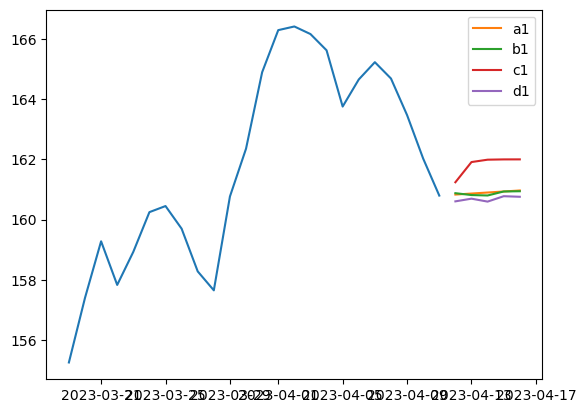

In [45]:
plt.plot(prices[4330:])
plt.plot(a1,label='a1')
plt.plot(b1,label='b1')
plt.plot(c1,label='c1')
plt.plot(d1,label='d1')
plt.legend()

# Sentiment Analysis 

In [46]:
# Credentials for Accessing reddit 
import praw 
from textblob import TextBlob
reddit = praw.Reddit(
    client_id="4trXuOtelGg37wXMYMCrIQ",
    client_secret="yqXz4zO8e8tJj_LXqwF7BdwWgL2M-g",
    password="abcd@123",
    user_agent="USERAGENT",
    username="Royal-Cartoonist-217",
)

In [47]:
stockname=input("Enter the Stock Name: -  ")
l=[]
for comment in reddit.subreddit(stockname).hot(limit=250):
    l.append(comment.title)
polarity=0
subjectivity=0
for i in range(len(l)):
    blob1=TextBlob(l[i])
    polarity+=blob1.sentiment.polarity
    subjectivity+=blob1.sentiment.subjectivity
polarity=polarity/len(l)
subjectivity=subjectivity/len(l)

In [48]:
if polarity > 0:
    if polarity > 0.5:
        sentimentpolarity="Positive"
    else:
        sentimentpolarity="Less Positive"
elif polarity <0:
    if polarity < -0.5:
        sentimentpolarity="Negative"
    else:
        sentimentpolarity="Less Negative"
else:
    sentimentpolarity = "Neutral"
print("The below statement is based on the title of hot topics on that stock name ")
print(f"The current Sentimnet polarity of the people on Reddit for the {stockname} stock is {sentimentpolarity} and the polarity is {polarity} and having a subjectivity of {subjectivity}")

The below statement is based on the title of hot topics on that stock name 
The current Sentimnet polarity of the people on Reddit for the amazon stock is Less Positive and the polarity is 0.03862020014617416 and having a subjectivity of 0.1420096137628605


In [49]:
def get_mass_opinion(m):
    print("\n Execution of Mass Opinion Function \n")
    polarity=0
    subjectivity=0
    for i in range(len(m)):
        blob1=TextBlob(l[i])
        polarity+=blob1.sentiment.polarity
        subjectivity+=blob1.sentiment.subjectivity
    polarity=polarity/len(m)
    subjectivity=subjectivity/len(m)
    if polarity > 0:
        if polarity > 0.5:
            sentimentpolarity="Positive"
        else:
            sentimentpolarity="Less Positive"
    elif polarity <0:
        if polarity < -0.5:
            sentimentpolarity="Negative"
        else:
            sentimentpolarity="Less Negative"
    else:
        sentimentpolarity = "Neutral"
    print("The below statement is based on mass opinion on that stock name and will generate signals based on whether to buy or sell")
    print(f"The current Sentimnet polarity of the people on Reddit for the {stockname} stock is {sentimentpolarity} and the polarity is {polarity} and having a subjectivity of {subjectivity}")
    print("Based on the sentiments if the sentiment polarity comes out to be positive we will buy the stock and will sell if the sentiment polarity comes out to be negative ")
    return None

In [50]:
#keywords = ['stock', 'stocks', 'equity', 'invest', 'investing', 'investor', 'investment', 'portfolio', 'shares', 'dividend', 'dividends', 'trading', 'trade', 'market', 'bullish', 'bearish', 'price', 'earnings', 'valuation', 'growth', 'income', 'financial', 'fundamental', 'technical', 'analysis', 'profit', 'loss', 'buy', 'sell', 'hold', 'market capitalization', 'market cap', 'volatility', 'return', 'risk', 'asset', 'securities', 'index', 'exchange', 'sector', 'industry', 'blue chip', 'small cap', 'large cap', 'mid cap', 'penny stock', 'hot stock', 'trend', 'momentum', 'liquidity', 'volume', 'wall street', 'main street', 'inflation', 'deflation', 'interest rates', 'federal reserve', 'economic', 'macro', 'micro', 'global', 'domestic', 'currency', 'commodity', 'option', 'futures', 'ETF', 'mutual fund', 'hedge fund', 'broker', 'analyst', 'rating', 'outlook', 'earnings call', 'dividend yield', 'EPS', 'P/E ratio', 'P/B ratio', 'market sentiment', 'market trend']
#keywords.append(stockname)
m=[]
print("Due to less data bieng spoken about the stock as of now we are not using the stock based analysis on the stream")
for comment in reddit.subreddit("wallstreetbets").stream.comments():
    #if stockname.lower() in comment.body.lower():, I am not using this statemnet as of now as we have less data 
        # getting the sentiment based on the comments 
    redditcomment=comment.body
    blob2=TextBlob(redditcomment)
    sent=blob2.sentiment
    if sent.polarity!=0:
        m.append(redditcomment) # I will use this later for mass thoughts of people on reddit based on 500 threshold 
    print(f"Sentiment for the follwing comment is: -{redditcomment} is {sent.polarity} with a subjectivity of {sent.subjectivity}")
    if len(m) == 10:# threshold for the m 
        k=get_mass_opinion(m)
        m=[]# again assigning m to be an empty list so as to againn get 100 comments first 
            # this function is only defined for the peak time in the stock markets 
            

Due to less data bieng spoken about the stock as of now we are not using the stock based analysis on the stream
Sentiment for the follwing comment is: -I know I'm a degenerate gambler when I've moved my money to a sweepstakes bank with less than average yearly interest. is -0.15833333333333333 with a subjectivity of 0.2333333333333333
Sentiment for the follwing comment is: -Money is 100% happiness is 0.7 with a subjectivity of 0.2
Sentiment for the follwing comment is: -#big 🦇 is 0.0 with a subjectivity of 0.1
Sentiment for the follwing comment is: -It is not that when CPI goes up prices rise...it is the other way around. Puts on ChatGPT is -0.125 with a subjectivity of 0.375
Sentiment for the follwing comment is: -#I INVEST IN NATIONAL GEOGRAPHIC FOR THE 0.01% DIVIDEND is 0.0 with a subjectivity of 0.0
Sentiment for the follwing comment is: -Which MSM has label crapitalism is 0.0 with a subjectivity of 0.0
Sentiment for the follwing comment is: -Pics is 0.0 with a subjectivity of 0.0
